<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/din_pl_STLM__passos_diferents.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

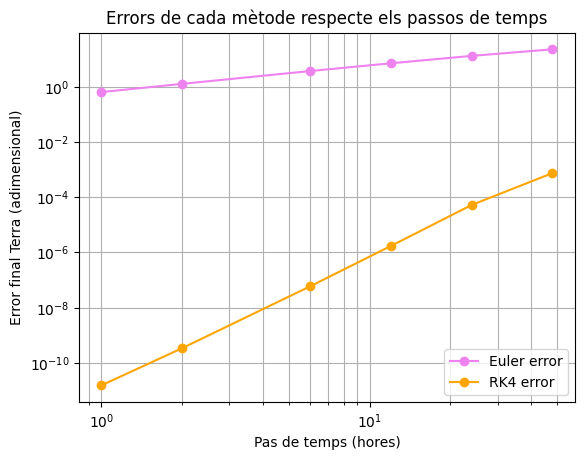

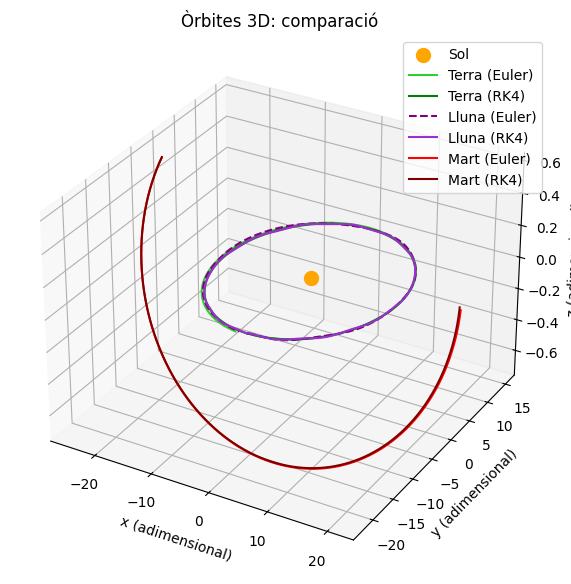

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Dades en unitats del SI
G= 6.67430e-11
m_sol= 1.98847e30
m_terra= 5.97219e24
m_lluna= 7.349e22
m_mart= 6.4171e23

# Condicions inicials (en cartesianes)
# L'origen és el baricentre del sistema solar
# Format: [x,y,z,vx,vy,vz]
# Inici a les 13:59 del 21 de Juliol del 2025 (solstici d'estiu)
# Això és per el temps central Europeu, per tant hi ha un lleuger error
# Ja que no està a Bellaterra/Barcelona exactament
# Posicions en kilometres i velocitats en km/s

lluna= np.array([-1.223926839954494E+05, -1.526112945830738E+08, 5.512426765490323E+04, 2.865929048320844E+01, 7.673984990113614E-01, 6.367954754048094E-02])
terra= np.array([-4.133776082794621E+05, -1.528302631740358E+08, 3.242787546376139E+04, 2.932642969193051E+01, -7.378251008835289E-02, -1.172300942425906E-03])
sol= np.array([-6.709778526787314E+05, -8.035450223548296E+05, 2.366174814126350E+04, 1.263745636318025E-02, -3.212119035252178E-03, -2.265926685896345E-04])
mart= np.array([-2.457240245390437E+08, -2.253913894859833E+07, 5.577461384361338E+06, 3.057555929366051E+00, -2.206677199548648E+01, -5.372712135532627E-01])

# Normalització
t0= 86400.0            # Temps característic= 1 dia
m0= m_sol              # Massa característica= massa del sol
r0= (G * t0**2 * m0)**(1/3)  # Radi característic a partir de les dues constants anteriors

def normalitza(cos): # Primer passem a m i m/s, després normalitzem
  pos= cos[:3] * 1e3 / r0
  vel= cos[3:] * 1e3 * (t0 / r0)
  return pos, vel

masses= np.array([m_sol/m0, m_terra/m0, m_lluna/m0, m_mart/m0])
pos_sol, vel_sol= normalitza(sol)
pos_terra, vel_terra= normalitza(terra)
pos_lluna, vel_lluna= normalitza(lluna)
pos_mart, vel_mart= normalitza(mart)
posicions= np.array([pos_sol, pos_terra, pos_lluna, pos_mart])
velocitats= np.array([vel_sol, vel_terra, vel_lluna, vel_mart])

def acceleracions(pos, masses): # pos és matriu N files i 3 columnes
    N= len(masses) # Nombre de planetes
    acc= np.zeros_like(pos) # Crea un array amb la mateixa forma que pos però ple de zeros
    for i in range(N):
        for j in range(N):
            if i != j:  # Si i ≠ j, perquè un cos no s'atrau a ell mateix
                diff= pos[j] - pos[i]
                d= np.linalg.norm(diff) # Calcula la norma del vector diferència de posicions
                acc[i]= acc[i] + masses[j] * diff / d**3
    return acc

def euler(pos, vel, masses, h):
    acc_euler= acceleracions(pos, masses)
    vel_nou= vel + h * acc_euler
    pos_nou= pos + h * vel
    return pos_nou, vel_nou

def rk4(pos, vel, masses, h):
    K1= vel
    L1= acceleracions(pos, masses)
    K2= vel + 0.5*h*L1
    L2= acceleracions(pos + 0.5*h*K1, masses)
    K3= vel + 0.5*h*L2
    L3= acceleracions(pos + 0.5*h*K2, masses)
    K4= vel + h*L3
    L4= acceleracions(pos + h*K3, masses)
    pos_nou= pos + (h/6)*(K1 + 2*K2 + 2*K3 + K4)
    vel_nou= vel + (h/6)*(L1 + 2*L2 + 2*L3 + L4)
    return pos_nou, vel_nou

# Apliquem aquestes funcions a una simulació de duració 1 any terrestre
dies= 365
h= 1/8 #1/24 és cada hora, 1/8 lluna euler explota
passos = int(dies / h)
trajectoria_euler= np.zeros((passos+1, 4, 3))
trajectoria_rk4  = np.zeros((passos+1, 4, 3))
pos_euler, vel_euler= posicions.copy(), velocitats.copy()
pos_rk4, vel_rk4= posicions.copy(), velocitats.copy()
trajectoria_euler[0]= pos_euler
trajectoria_rk4[0]  = pos_rk4

for k in range(passos):
    pos_euler, vel_euler= euler(pos_euler, vel_euler, masses, h)
    pos_rk4, vel_rk4= rk4(pos_rk4, vel_rk4, masses, h)
    trajectoria_euler[k+1]= pos_euler
    trajectoria_rk4[k+1]  = pos_rk4


# GRÀFIC ERROR VS PAS DEL TEMPS (Euler i RK4 per separat)
dies = 365
hs = [1/24, 2/24, 6/24, 12/24, 1, 2]   # (dies) -> 1h,2h,6h,12h,1d,2d

h_ref = (10/60)/24  # 10 min en dies
passos_ref = int(round(dies / h_ref))

# Referència RK4
traj_ref = np.zeros((passos_ref+1, 4, 3))
pos_ref, vel_ref = posicions.copy(), velocitats.copy()
traj_ref[0] = pos_ref
for k in range(passos_ref):
    pos_ref, vel_ref = rk4(pos_ref, vel_ref, masses, h_ref)
    traj_ref[k+1] = pos_ref

# Errors (error FINAL de la Terra respecte la referència)
err_euler = []
err_rk4   = []
dt_hours  = []

for h in hs:
    passos = int(round(dies / h))

    # Simulació Euler i RK4 amb aquest h
    traj_e = np.zeros((passos+1, 4, 3))
    traj_r = np.zeros((passos+1, 4, 3))
    pos_e, vel_e = posicions.copy(), velocitats.copy()
    pos_r, vel_r = posicions.copy(), velocitats.copy()
    traj_e[0] = pos_e
    traj_r[0] = pos_r

    for k in range(passos):
        pos_e, vel_e = euler(pos_e, vel_e, masses, h)
        pos_r, vel_r = rk4(pos_r, vel_r, masses, h)
        traj_e[k+1] = pos_e
        traj_r[k+1] = pos_r

    # Mostreig de la referència als mateixos instants
    stride = int(round(h / h_ref))
    ref_s = traj_ref[::stride]

    L = min(len(ref_s), len(traj_e), len(traj_r))
    ref_s = ref_s[:L]
    traj_e = traj_e[:L]
    traj_r = traj_r[:L]

    # Error final Terra (índex 1)
    err_euler.append(np.linalg.norm(traj_e[-1,1] - ref_s[-1,1]))
    err_rk4.append(np.linalg.norm(traj_r[-1,1] - ref_s[-1,1]))
    dt_hours.append(h * 24)

err_euler = np.array(err_euler)
err_rk4   = np.array(err_rk4)
dt_hours  = np.array(dt_hours)

plt.figure()
plt.loglog(dt_hours, err_euler, marker="o", color='violet', label="Euler error")
plt.loglog(dt_hours, err_rk4,   marker="o", color='orange', label="RK4 error")
plt.xlabel("Pas de temps (hores)")
plt.ylabel("Error final Terra (adimensional)")
plt.title("Errors de cada mètode respecte els passos de temps")
plt.legend()
plt.grid(True, which="both")
plt.show()

# # GRÀFIC ERROR TOTAL
# def simula(h, dies=365):
#     passos = int(round(dies / h))
#     trajectoria_euler = np.zeros((passos+1, 4, 3))
#     trajectoria_rk4   = np.zeros((passos+1, 4, 3))

#     pos_euler, vel_euler = posicions.copy(), velocitats.copy()
#     pos_rk4,   vel_rk4   = posicions.copy(), velocitats.copy()

#     trajectoria_euler[0] = pos_euler
#     trajectoria_rk4[0]   = pos_rk4

#     for k in range(passos):
#         pos_euler, vel_euler = euler(pos_euler, vel_euler, masses, h)
#         pos_rk4,   vel_rk4   = rk4(pos_rk4, vel_rk4, masses, h)
#         trajectoria_euler[k+1] = pos_euler
#         trajectoria_rk4[k+1]   = pos_rk4

#     return trajectoria_euler, trajectoria_rk4

# hores = np.array([1, 2, 4, 6, 12, 24, 48])  # en hores
# hs = hores / 24.0                           # en dies
# errors = []

# for h in hs:
#     traj_e, traj_r = simula(h, dies=365)

#     # posició final de la Terra
#     rE = traj_e[-1, 1]   # Euler
#     rR = traj_r[-1, 1]   # RK4

#     err = np.linalg.norm(rE - rR)  # en unitats adimensionals
#     errors.append(err)

# errors = np.array(errors)
# plt.figure()
# plt.loglog(hores, errors, marker="o")
# plt.xlabel("Pas de temps (hores)")
# plt.ylabel("||r_Euler - r_RK4||")
# plt.title("Error total: Euler i RK4")
# plt.grid(True, which="both")
# plt.show()


# GRÀFIC COMPARATIU EN 3D TRAJECTÒRIES
fig= plt.figure(figsize=(8,7))
ax= fig.add_subplot(111, projection="3d")
ax.scatter(trajectoria_rk4[0,0,0], trajectoria_rk4[0,0,1], trajectoria_rk4[0,0,2], color="orange", s=100, label="Sol")

ax.plot(trajectoria_euler[:,1,0], trajectoria_euler[:,1,1], trajectoria_euler[:,1,2], label="Terra (Euler)", color="limegreen")
ax.plot(trajectoria_rk4[:,1,0], trajectoria_rk4[:,1,1], trajectoria_rk4[:,1,2], label="Terra (RK4)", color="green")
ax.plot(trajectoria_euler[:,2,0], trajectoria_euler[:,2,1], trajectoria_euler[:,2,2], label="Lluna (Euler)", color="purple", linestyle="--")
ax.plot(trajectoria_rk4[:,2,0], trajectoria_rk4[:,2,1], trajectoria_rk4[:,2,2], label="Lluna (RK4)", color="darkorchid")
ax.plot(trajectoria_euler[:,3,0], trajectoria_euler[:,3,1], trajectoria_euler[:,3,2], label="Mart (Euler)", color="red")
ax.plot(trajectoria_rk4[:,3,0], trajectoria_rk4[:,3,1], trajectoria_rk4[:,3,2],label="Mart (RK4)", color="maroon")

ax.set_xlabel("x (adimensional)")
ax.set_ylabel("y (adimensional)")
ax.set_zlabel("z (adimensional)")
ax.set_title("Òrbites 3D: comparació")
ax.legend()
plt.show()

